In [16]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import rand
from scipy import interpolate
#for plotting
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (12,4)
plt.rc('legend', fontsize=8)
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

np.set_printoptions(precision=3) #Prints only three digits behind the , in decimals

## Task 2
### 2a)

In [17]:
#With inspiration from provided notebook about FEM
def loc2glob(k,alpha):
    return k+alpha          # Numbering k from 0

def FEM(x,f,a,b,c, print_A=False):
    if c<=abs(b**2)/(2*a): print("Warning: condition on c not met")
    N = len(x)-1
    H = np.diff(x)
    #Load vector
    Fk = f(x, a, b, c) #From 1 to -1 to implement boundary to conditions (ignoring the first and last term)
    #Seting up elemental stiffness matrix
    Ak1 = np.array([[1,-1],[-1,1]]) #must divide by step length
    Ak2 = 1/2 * np.array([[-1, 1], [-1, 1]])
    Ak3 = 1/6 * np.array([[2, 1],[1,2]]) #must multiply by step length

    A = np.zeros((N+1,N+1))
    F = np.zeros(N+1)

    for k in range(N): #Assembly
        for alpha in range(2): 
            i = loc2glob(k,alpha)
            for beta in range(2):
                j = loc2glob(k,beta)
                A[i,j] += a*Ak1[alpha,beta]/H[k] + b*Ak2[alpha,beta] + c*Ak3[alpha,beta]*H[k]
            F[i] += Fk[i]*H[k]/2

    U = np.zeros(N+1)
    U[1:-1] = np.linalg.solve(A[1:-1, 1:-1], F[1:-1])
    if print_A: print(A)
    return U

In [18]:
np.random.seed(0) #set seed
#Configuration of coefficients
a, b, c = 1, 2, 3
N = 7

#Defining right hand side
def f(x, a, b, c):
    return (c * np.sin(((3 * np.pi) * x))) + (((9 * a) * np.pi**2) * np.sin(((3 * np.pi) * x))) + (((3 * b) * np.pi) * np.cos(((3 * np.pi) * x)))

x = np.concatenate(([0.],np.sort(rand(N-1)), [1.]))
U = FEM(x, f, a, b, c, print_A=True)

[[   1.784   -1.149    0.       0.       0.       0.       0.       0.   ]
 [  -3.149   11.154   -7.188    0.       0.       0.       0.       0.   ]
 [   0.      -9.188  262.806 -253.43     0.       0.       0.       0.   ]
 [   0.       0.    -255.43   273.026  -17.509    0.       0.       0.   ]
 [   0.       0.       0.     -19.509   41.818  -22.164    0.       0.   ]
 [   0.       0.       0.       0.     -24.164   37.729  -13.396    0.   ]
 [   0.       0.       0.       0.       0.     -15.396   18.296   -2.369]
 [   0.       0.       0.       0.       0.       0.      -4.369    4.796]]


### 2b) 
We now want to explore the convergence rate of our method in both $L^2$ and $H^1$. To simplify, we will use equispaced step lengths instead of random step lengths. Then we check the error, compared to the exact solution, for different step lengths and find the coefficient of the slope from a log-log plot. 

In [19]:
def convergence(u_exact, solver, N=50, P=4, **kwargs): 
    Hconv, EL2, EH1 = np.zeros(P), np.zeros(P), np.zeros(P)

    for p in range(P): #For P different step lengths, they half each iteratiorn
        x = np.linspace(0,1,N+1)
        h = x[1]-x[0]
        Hconv[p] = h
        U = solver(x,**kwargs)
        Eh = u_exact(x)-U
        N = 2*N
        #compute L2 and H1 norm by composite trapezoid method
        EL2[p] = np.sqrt(np.sum(Eh**2) * h) 
        EH1[p] = np.sqrt(EL2[p]**2 + 2*np.sum(Eh**2)/h)

    orderL2 = np.polyfit(np.log(Hconv),np.log(EL2),1)[0]
    orderH1 = np.polyfit(np.log(Hconv),np.log(EH1),1)[0]
    return Hconv, (EL2, orderL2), (EH1, orderH1)

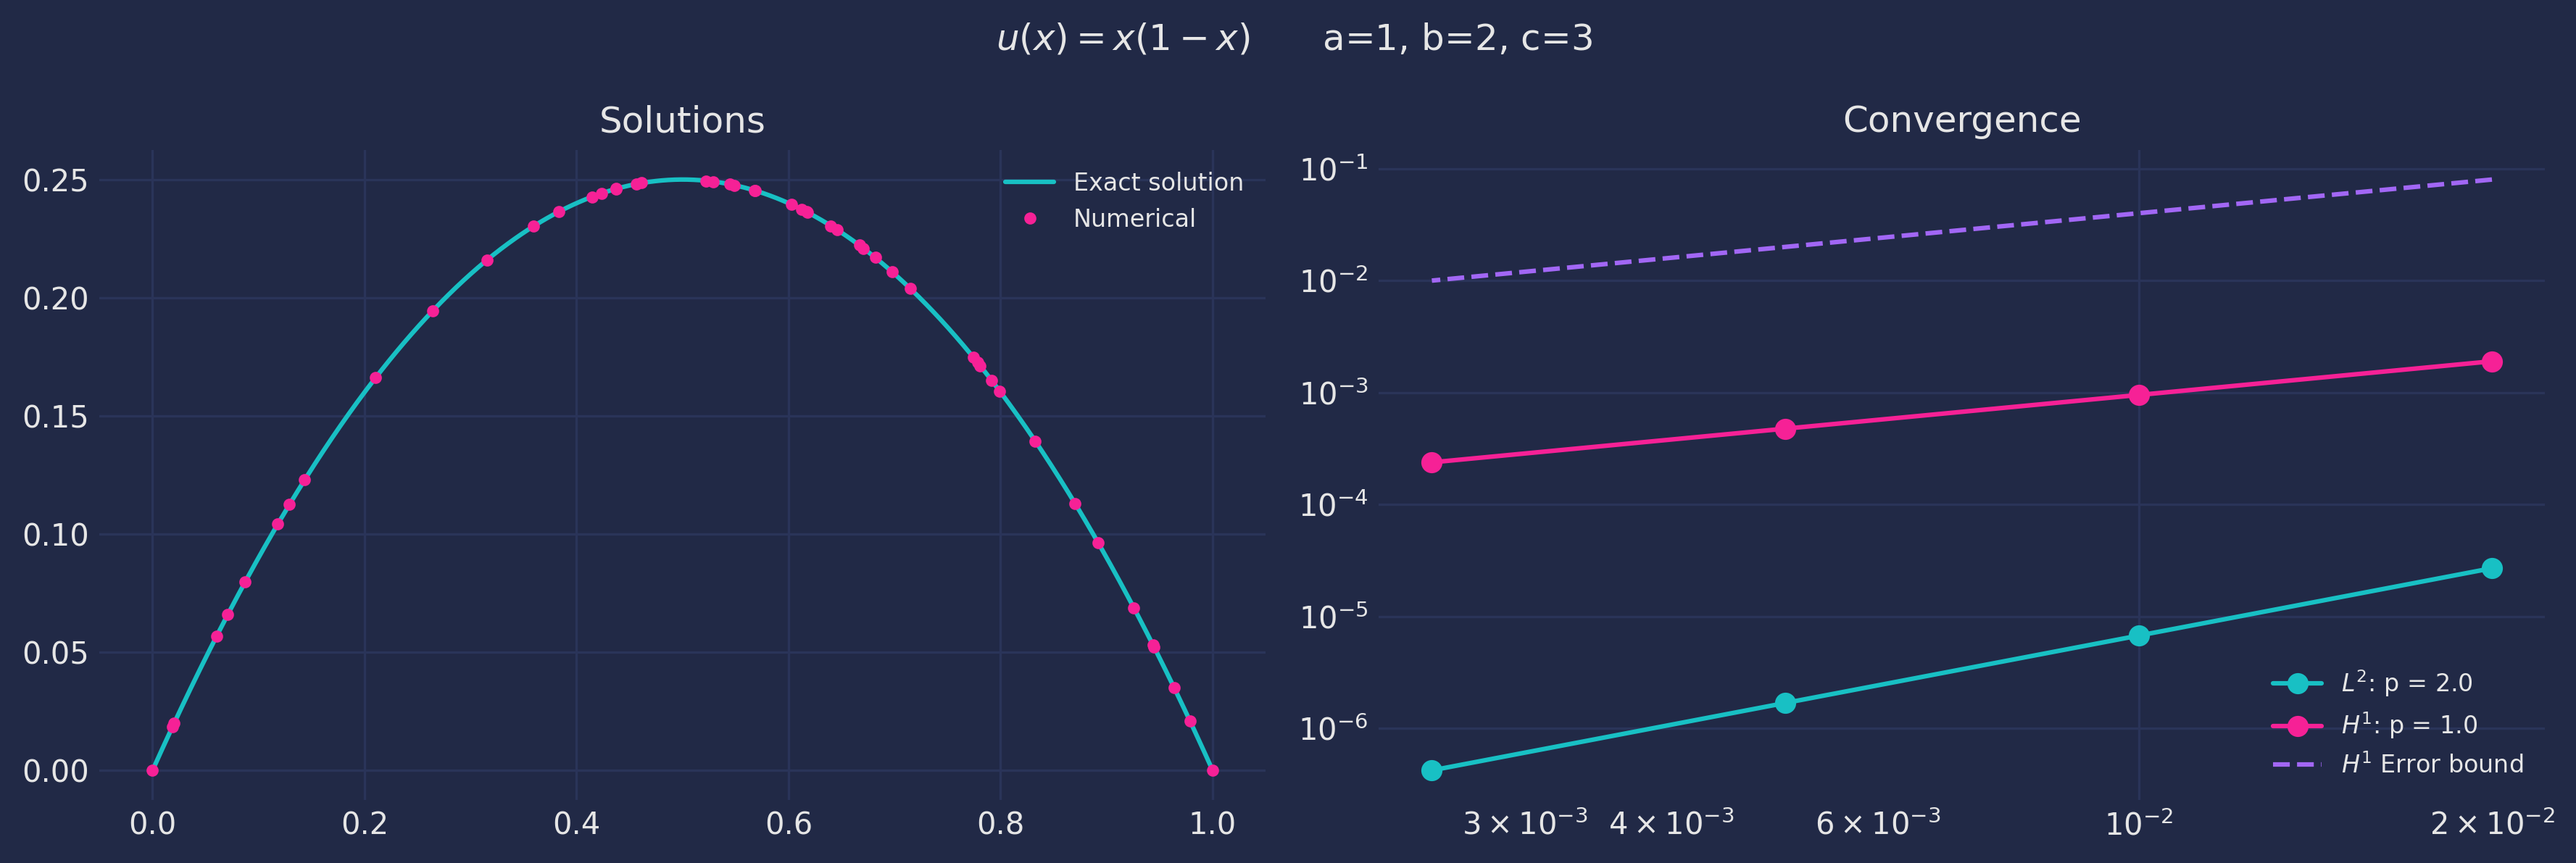

In [20]:
np.random.seed(0) #set seed
a, b, c = 1, 2, 3
N = 50

def f(x, a, b, c):
    return c *(-x**2 + x) + b *(-2 *x + 1) + 2*a
def u_exact(x):
    return x*(1-x)

x = np.concatenate(([0.],np.sort(rand(N-1)), [1.]))
xe = np.linspace(0,1,1000) #for prettier plot of exact solution
U = FEM(x,f,a,b,c)

fig, axs = plt.subplots(1, 2)
fig.suptitle(r"$u(x)=x(1-x)\qquad$" + f"a={a}, b={b}, c={c}")
axs[0].set_title("Solutions")
axs[0].plot(xe, u_exact(xe), label="Exact solution")
axs[0].plot(x, U, '.', label="Numerical")
axs[0].legend(loc=1)

H, EL2_res, EH1_res = convergence(u_exact, FEM, P=4, f=f, a=a, b=b, c=c)

axs[1].set_title("Convergence")
axs[1].loglog(H, EL2_res[0], "o-", label=rf"$L^2$: p = {EL2_res[1]:.2}")
axs[1].loglog(H, EH1_res[0], "o-", label=rf"$H^1$: p = {EH1_res[1]:.2}")
axs[1].loglog(H, H*4, "--", label = r"$H^1$ Error bound")
axs[1].legend(loc=4)
plt.tight_layout()
plt.savefig("x(1-x).png")
plt.show()

## 2c)

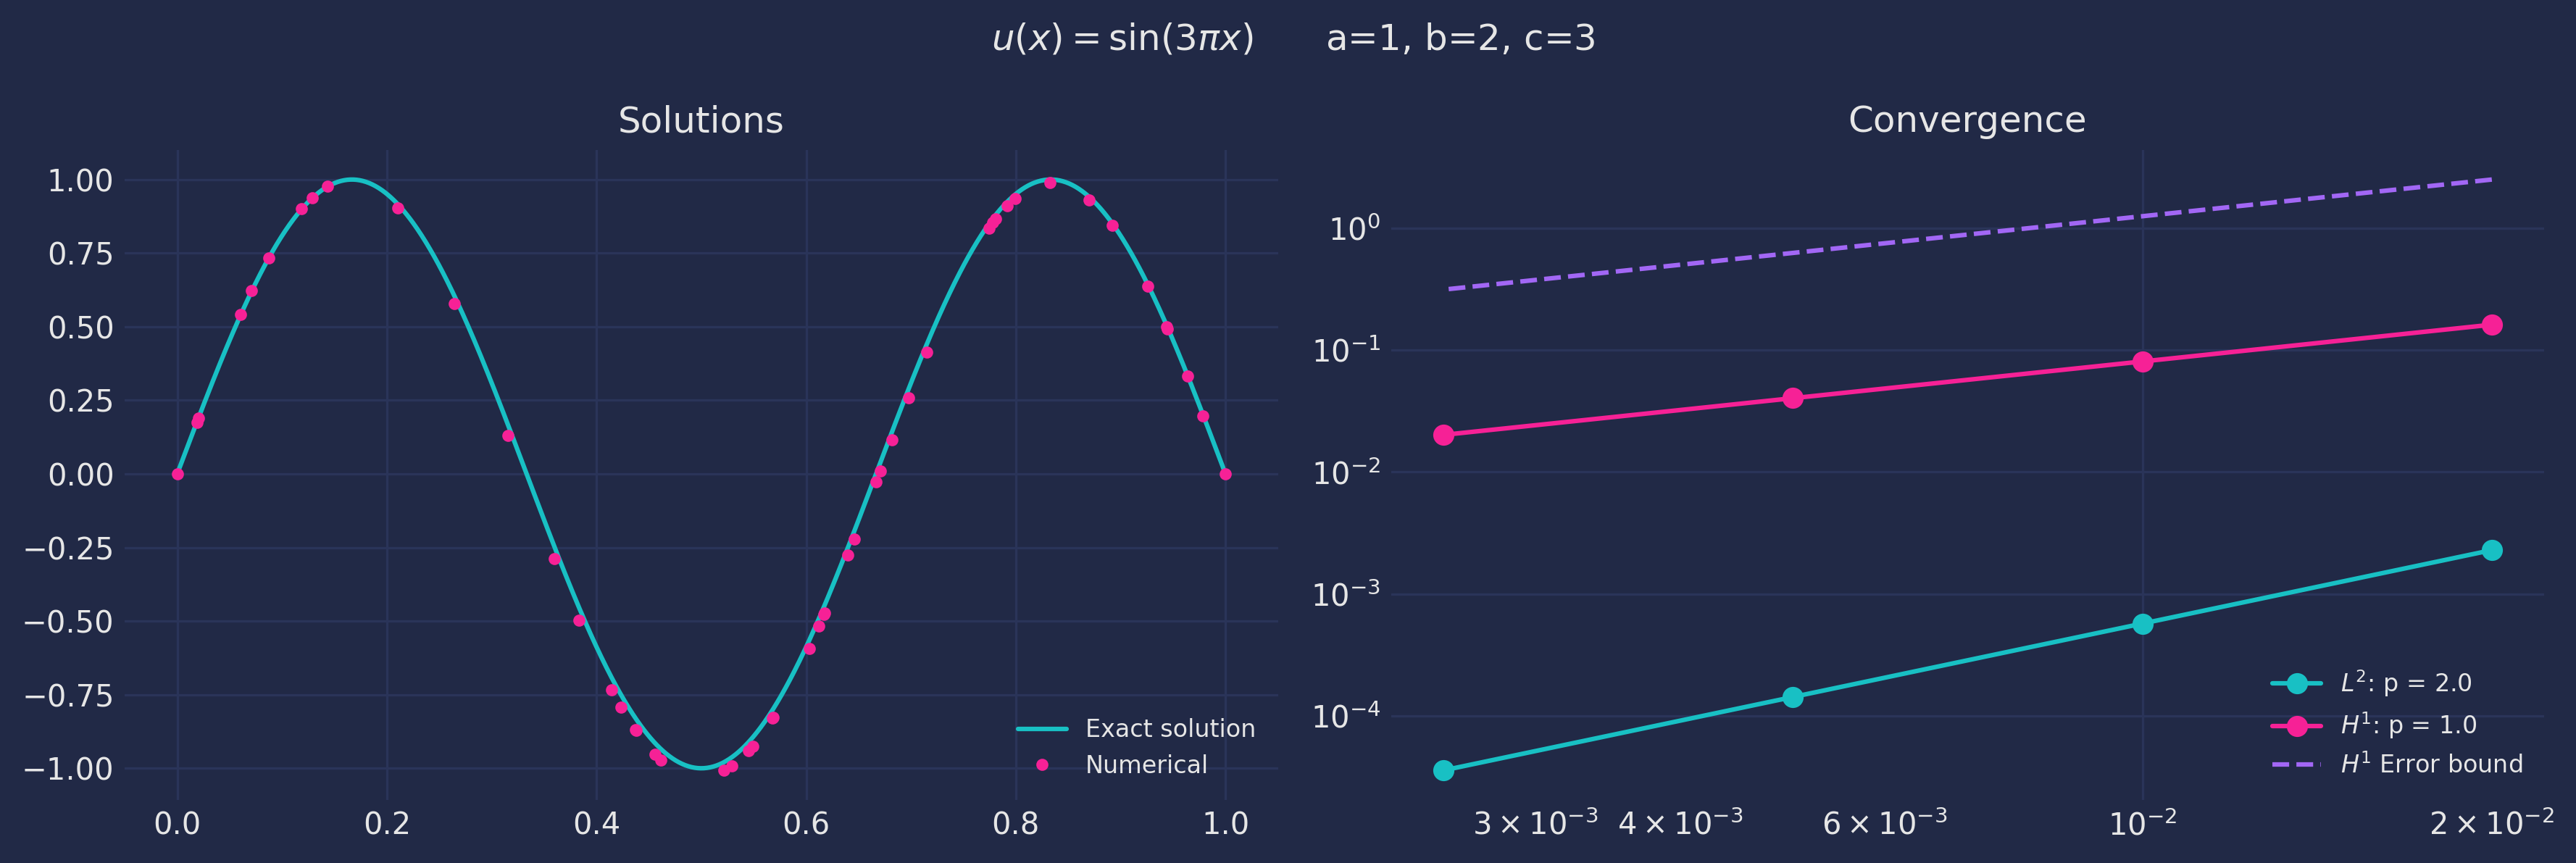

In [21]:
np.random.seed(0) #set seed
a, b, c = 1, 2, 3

def f(x, a, b, c):
    return c*np.sin(3*np.pi*x) + 9*a*np.pi**2*np.sin(3*np.pi*x) + 3*b*np.pi*np.cos(3*np.pi*x)

def u_exact(x):
    return np.sin(3*np.pi*x)

H, EL2_res, EH1_res = convergence(u_exact, FEM, P=4, f=f, a=a, b=b, c=c)

x = np.concatenate(([0.],np.sort(rand(N-1)), [1.]))
xe = np.linspace(0, 1, 1000)
U = FEM(x,f,a,b,c)

fig, axs = plt.subplots(1, 2)
fig.suptitle(r"$u(x)=\sin(3\pi x) \qquad$" + f"a={a}, b={b}, c={c}")
axs[0].set_title("Solutions")
axs[0].plot(xe, u_exact(xe), label="Exact solution")
axs[0].plot(x, U, '.', label="Numerical")
axs[0].legend(loc=4)

H, EL2_res, EH1_res = convergence(u_exact, FEM, P=4, f=f, a=a, b=b, c=c)

axs[1].set_title("Convergence")
axs[1].loglog(H, EL2_res[0], "o-", label=rf"$L^2$: p = {EL2_res[1]:.2}")
axs[1].loglog(H, EH1_res[0], "o-", label=rf"$H^1$: p = {EH1_res[1]:.2}")
axs[1].loglog(H, H*np.pi**2 * 9*np.sqrt(2), "--", label = r"$H^1$ Error bound")
axs[1].legend(loc=4)
plt.tight_layout()
plt.savefig("sin(3pix).png")
plt.show()

## 2d)

In [22]:
def FEMw1(x,a,b,c):
    assert(c>abs(b**2)/(2*a))
    N = len(x)-1
    H = np.diff(x)
    #Seting up elemental stiffness matrix
    Ak1 = np.array([[1,-1],[-1,1]]) #must divide by step length
    Ak2 = 1/2 * np.array([[-1, 1], [-1, 1]])
    Ak3 = 1/6 * np.array([[2, 1],[1,2]]) #must multiply by step length

    A = np.zeros((N+1,N+1))
    F = np.zeros(N+1)
    
    dhat_val = lambda alpha : -1 if alpha == 0 else 1

    integral11 = lambda a: 2*a
    integral12 = lambda x0, x1, b, h : (x1**2-x0**2)*b/h
    integral13 = lambda x0, x1, c, h : (2*x0**3 - 3*x0**2*x1 + x1**3)*c/(3*h)

    integral21 = lambda a: -2*a
    integral22 = lambda x0, x1, b, h : (x0**2 - 2*x0 - x1**2 + 2*x1)*b/h
    integral23 = lambda x0, x1, c, h : (-2*x0**3 + 3*x0**2*x1 + 3*x0**2 - 6*x0*x1 - x1**3 + 3*x1**2)*c/(3*h)
    
    for k in range(N):
        for alpha in range(2):
            i = loc2glob(k,alpha)
            for beta in range(2):
                j = loc2glob(k,beta)
                A[i,j] += a*Ak1[alpha,beta]/H[k] + b*Ak2[alpha,beta] + c*Ak3[alpha,beta]*H[k]
            if x[k] < 0.5:
                F[i] += dhat_val(alpha)*(integral11(a) - integral12(x[k], x[k+1], b, H[k]))
                if alpha == 0:
                    F[i] += integral13(x[k], x[k+1], c, H[k])
                else:
                    F[i] += integral13(x[k+1], x[k], c, H[k])
            else:
                F[i] += dhat_val(alpha)*(integral21(a) - integral22(x[k], x[k+1], b, H[k]))
                if alpha == 0:
                    F[i] += integral23(x[k], x[k+1], c, H[k])
                else:
                    F[i] += integral23(x[k+1], x[k], c, H[k])
    
    U = np.zeros(N+1)
    U[1:-1] = np.linalg.solve(A[1:-1, 1:-1], F[1:-1])
    return U

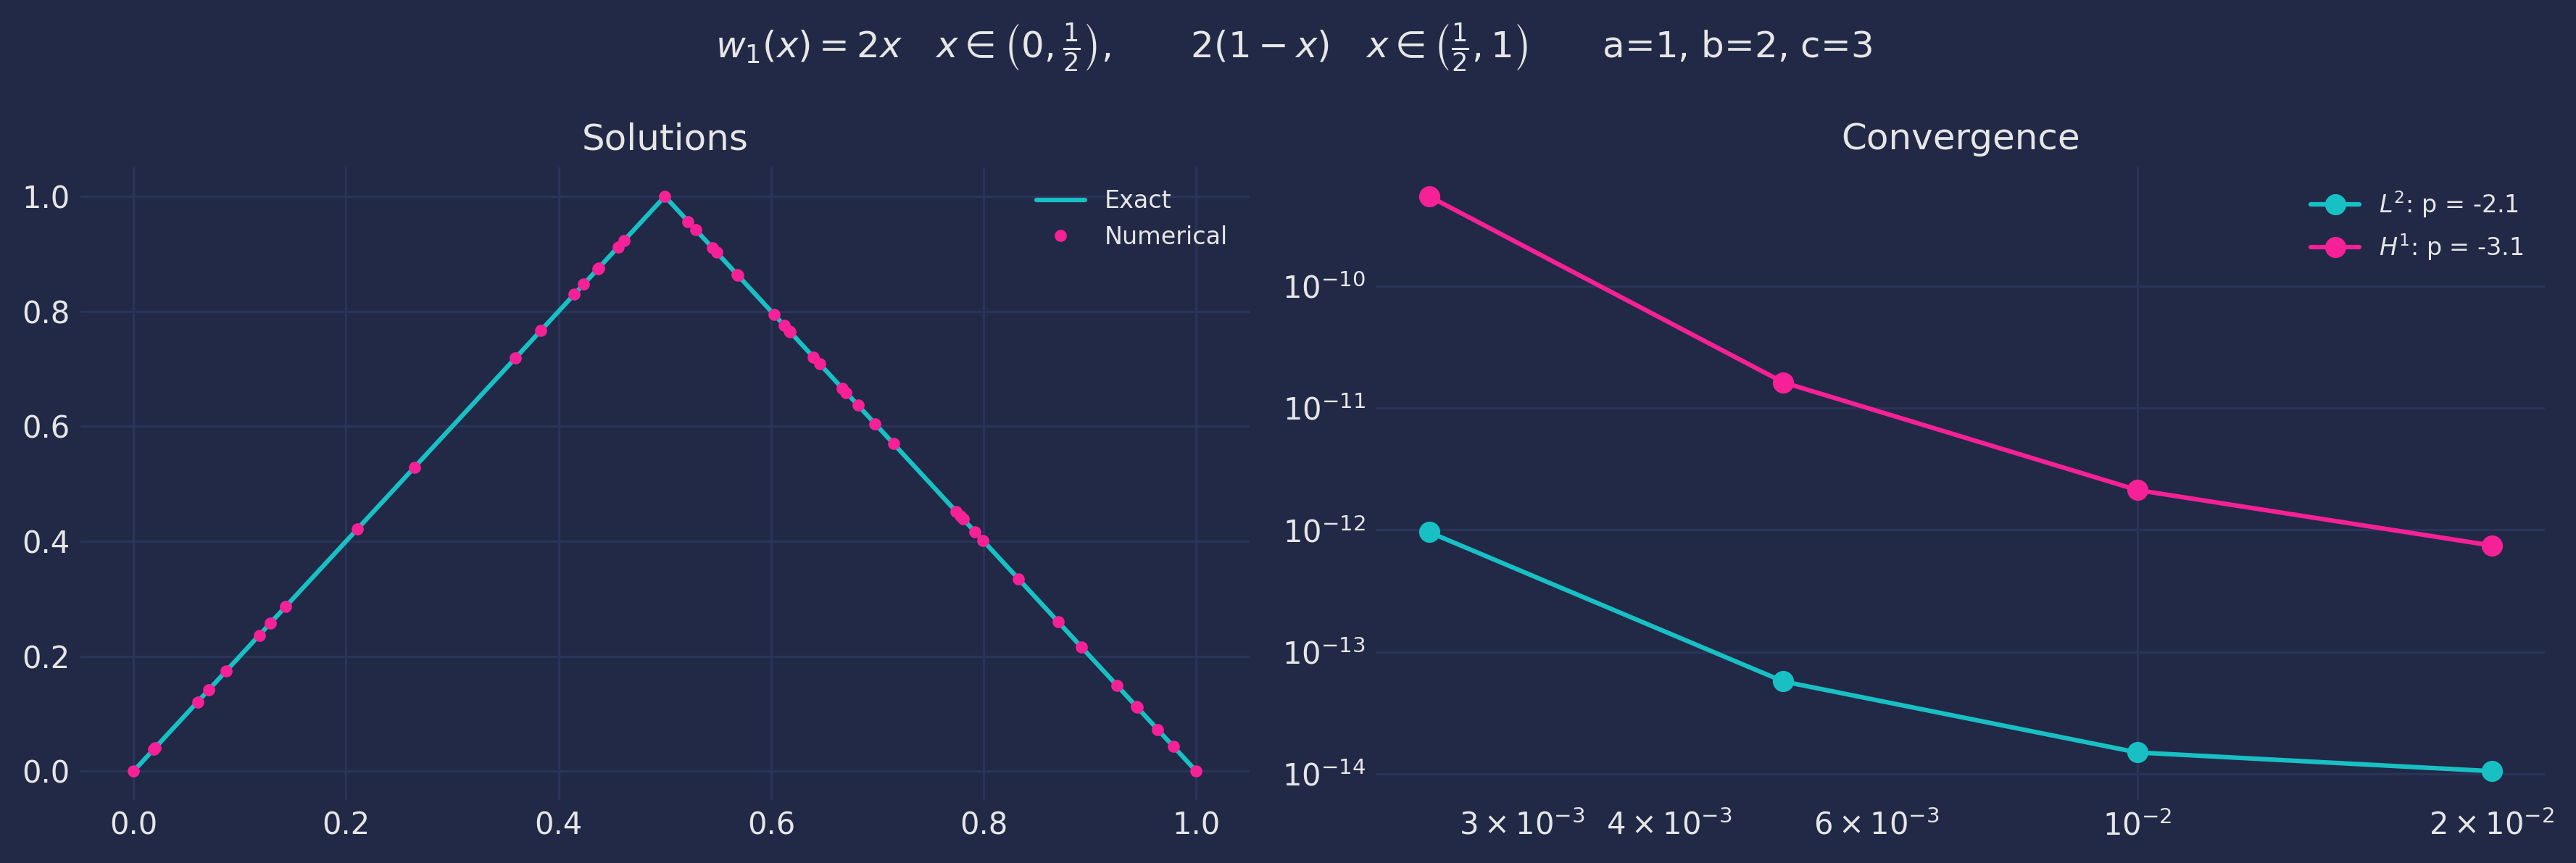

In [23]:
np.random.seed(0) #set seed
a, b, c = 1, 2, 3
N = 50

def w1(x):
    return np.where(x<=0.5, 2*x, 2*(1-x))

x = np.sort(np.concatenate((rand(N-2), [0., 0.5,1.])))
U = FEMw1(x,1,2,3)

fig, axs = plt.subplots(1,2)
fig.suptitle(r"$w_1(x)=2x \quad x \in \left(0, \frac{1}{2}\right), \qquad 2(1-x) \quad x \in \left(\frac{1}{2}, 1\right)\qquad$"+ f"a={a}, b={b}, c={c}")
axs[0].set_title("Solutions")
axs[0].plot(x, w1(x), label = "Exact")
axs[0].plot(x, U, '.', label = "Numerical")
axs[0].legend()

H, EL2_res, EH1_res = convergence(w1, FEMw1, a=a, b=b, c=c)

axs[1].set_title("Convergence")
axs[1].loglog(H, EL2_res[0], "o-", label=rf"$L^2$: p = {EL2_res[1]:.2}")
axs[1].loglog(H, EH1_res[0], "o-", label=rf"$H^1$: p = {EH1_res[1]:.2}")
axs[1].legend()
plt.tight_layout()
plt.savefig("w1.png")
plt.show()

In [24]:
def FEMw2(x,a,b,c):
    assert(c>abs(b**2)/(2*a))
    N = len(x)-1
    H = np.diff(x)
    #Seting up elemental stiffness matrix
    Ak1 = np.array([[1,-1],[-1,1]]) #must divide by step length
    Ak2 = 1/2 * np.array([[-1, 1], [-1, 1]])
    Ak3 = 1/6 * np.array([[2, 1],[1,2]]) #must multiply by step length

    A = np.zeros((N+1,N+1))
    F = np.zeros(N+1)
    
    dhat_val = lambda alpha : -1 if alpha == 0 else 1

    integral1 = lambda x0, x1, a, h : ((x1 - x1**(2/3)) - (x0 - x0**(2/3)))*a/h
    integral2 = lambda x0, x1, b, h : ((1/2*x1**2-3/5*x1**(5/3)) - (1/2*x0**2-3/5*x0**(5/3)))*b/h
    integral3 = lambda x0, x1, c, h : (-45*x0**2*x0**(2/3) - 27*x1**2*x1**(2/3) + 72*x0*x1*x0**(2/3) + 40*x0**3 + 20*x1**3 - 60*x0**2*x1)* c/(120*h)
    
    for k in range(N):
        for alpha in range(2):
            i = loc2glob(k,alpha)
            for beta in range(2):
                j = loc2glob(k,beta)
                A[i,j] += a*Ak1[alpha,beta]/H[k] + b*Ak2[alpha,beta] + c*Ak3[alpha,beta]*H[k]
            F[i] += dhat_val(alpha)*(integral1(x[k], x[k+1], a, H[k]) - integral2(x[k], x[k+1], b, H[k]))
            if alpha == 0:
                F[i] +=  integral3(x[k], x[k+1], c, H[k])
            else:
                F[i] += integral3(x[k+1], x[k], c, H[k])
    
    U = np.zeros(N+1)
    U[1:-1] = np.linalg.solve(A[1:-1, 1:-1], F[1:-1])
    return U

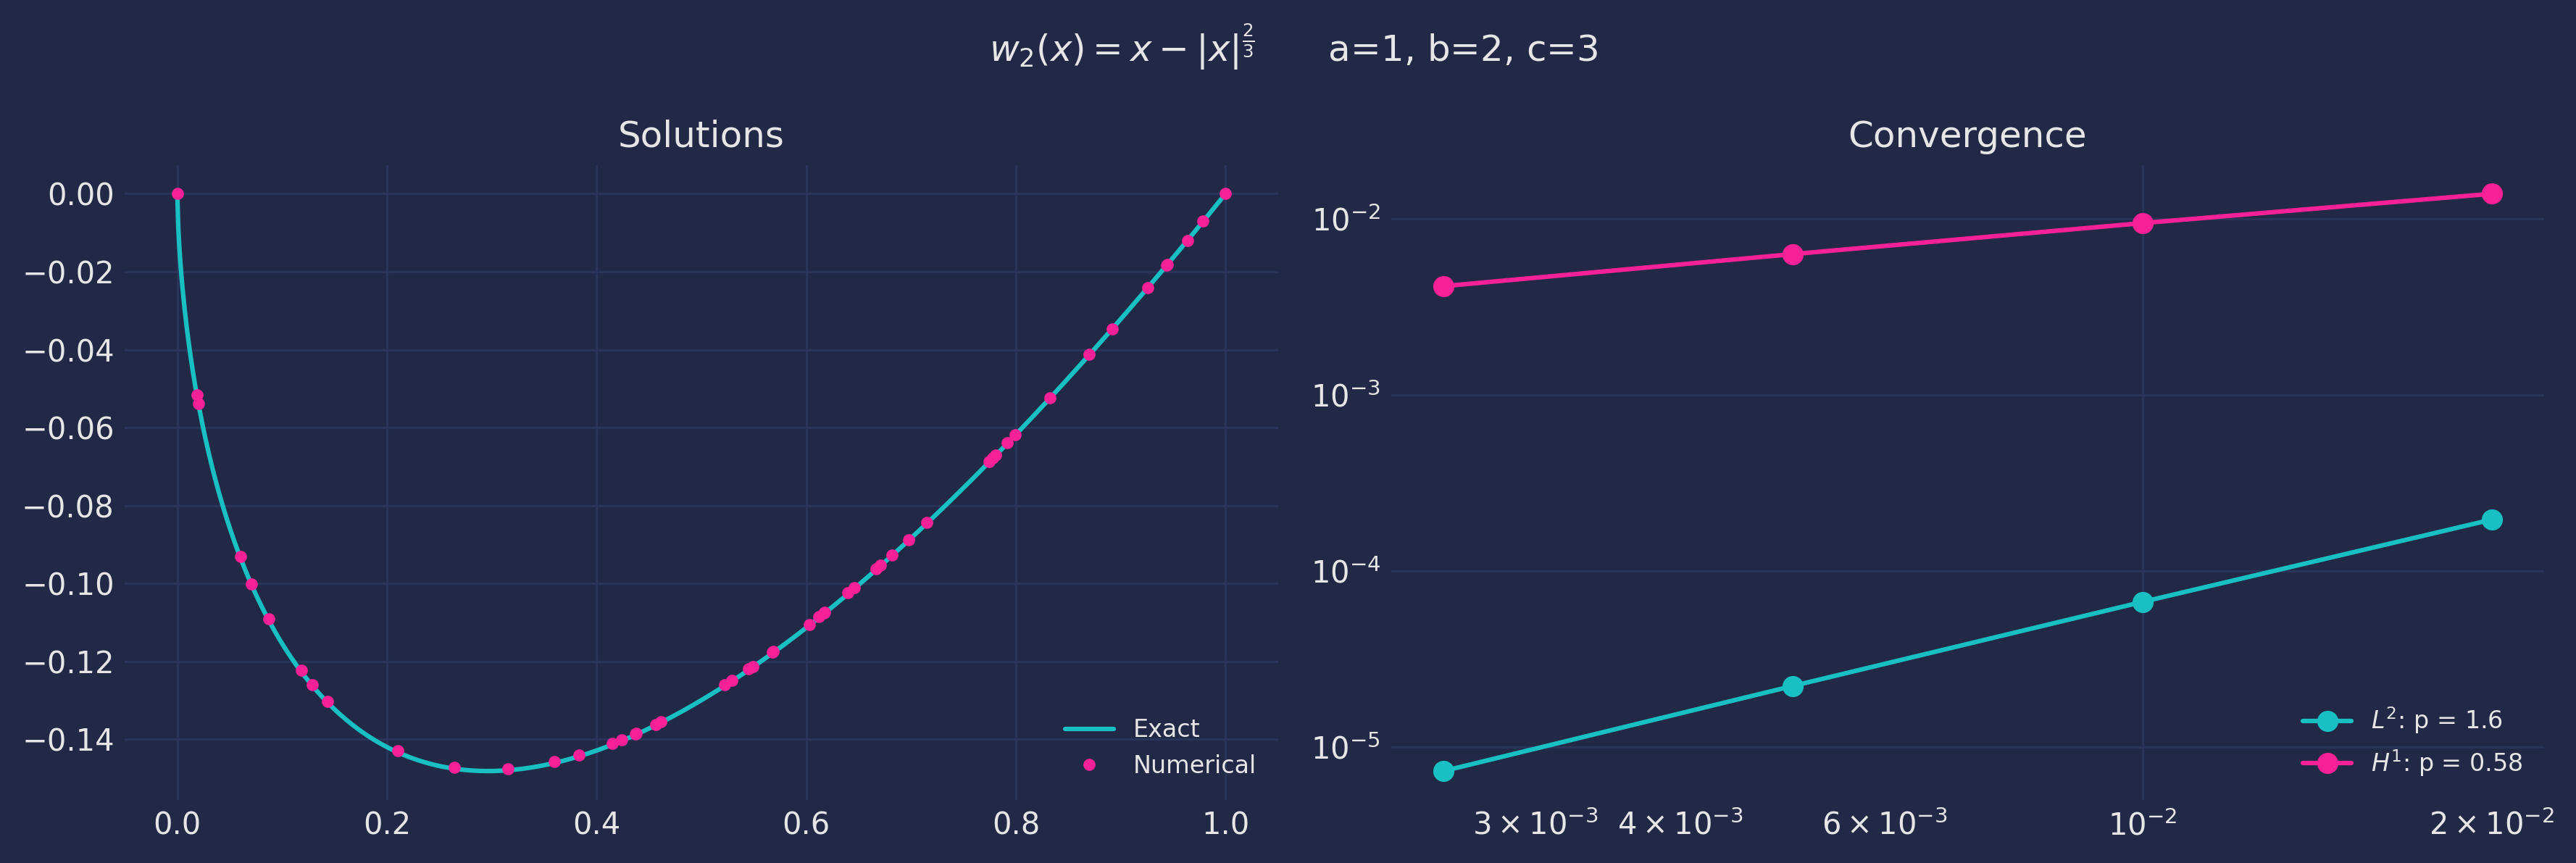

In [25]:
np.random.seed(0) #set seed
a, b, c = 1, 2, 3
N = 50

def w2(x):
    return x-np.abs(x)**(2/3)

x = np.concatenate(([0.],np.sort(rand(N-1)), [1.]))
xe = np.linspace(0, 1, 1000) #for smoother exact plot
U = FEMw2(x,a,b,c)

fig, axs = plt.subplots(1,2)
fig.suptitle(r"$w_2(x)=x-|x|^{\frac{2}{3}} \qquad$" + f"a={a}, b={b}, c={c}")
axs[0].set_title("Solutions")
axs[0].plot(xe, w2(xe), label = "Exact")
axs[0].plot(x, U, '.', label = "Numerical")
axs[0].legend()

H, EL2_res, EH1_res = convergence(w2, FEMw2, a=a, b=b, c=c)

axs[1].set_title("Convergence")
axs[1].loglog(H, EL2_res[0], "o-", label=rf"$L^2$: p = {EL2_res[1]:.2}")
axs[1].loglog(H, EH1_res[0], "o-", label=rf"$H^1$: p = {EH1_res[1]:.2}")
axs[1].legend()
plt.tight_layout()
plt.savefig("w2.png")
plt.show()

## 2e)

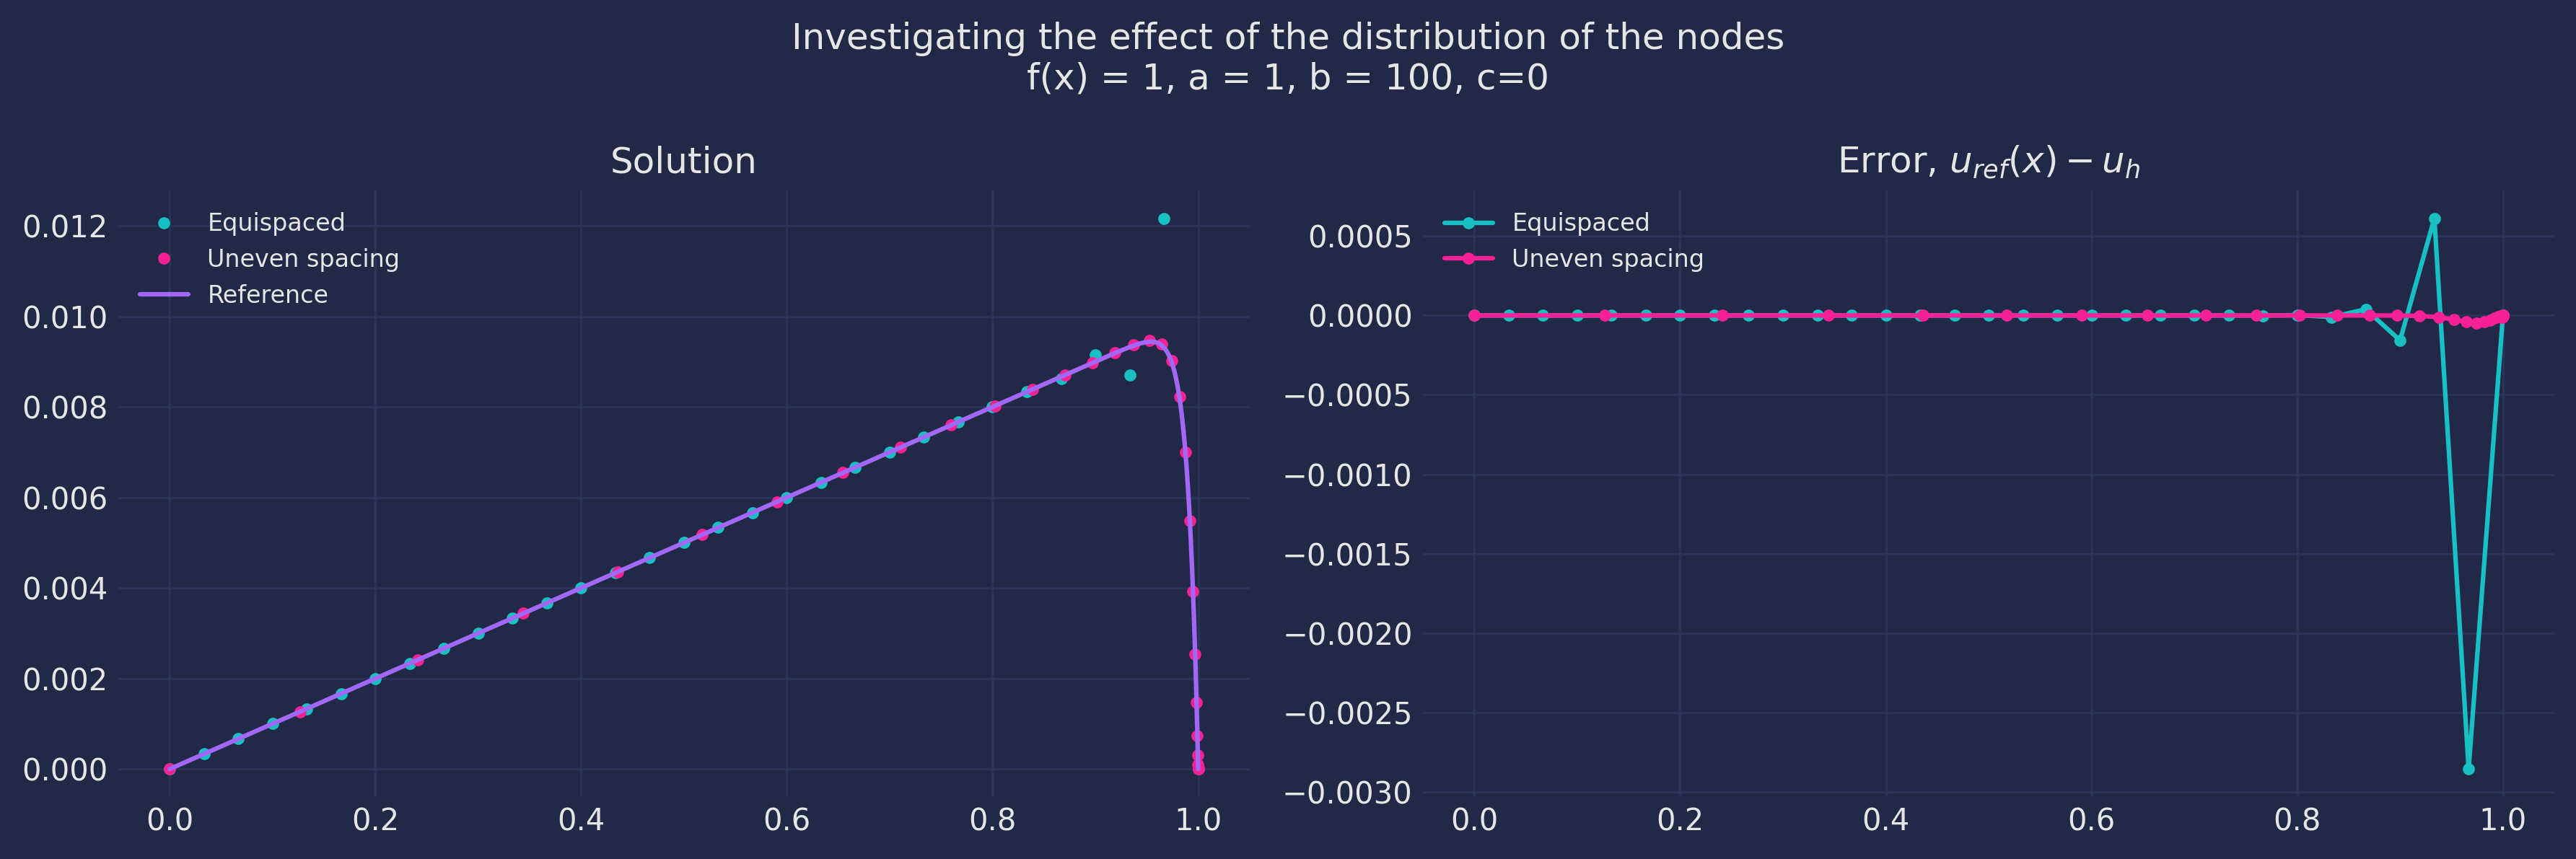

In [26]:
np.random.seed(0) #set seed
a, b, c = 1, 100, 0

def f(x, a, b, c):
    return np.ones_like(x)

N_ref = 1000 #number of subintervals for the reference solution
N = 30 #number of subintervals for the approximate solutions

x_ref = np.linspace(0, 1, N_ref+1) #equispaced, reference solution
x_equi = np.linspace(0, 1, N+1) #equispaced
x_uneven = 1-x_equi**4 #transform of the nodes so that they are closer towards x=1

U_equi = FEM(x_equi,f,a,b,c)
U_uneven = FEM(x_uneven,f,a,b,c)

U_ref = FEM(x_ref,f,a,b,c)
u_ref = interpolate.interp1d(x_ref, U_ref)

fig, axs = plt.subplots(1, 2)
fig.suptitle(r"Investigating the effect of the distribution of the nodes" + f"\nf(x) = 1, a = {a}, b = {b}, c={c}")
axs[0].set_title("Solution")
axs[0].plot(x_equi, U_equi, '.',label = "Equispaced")
axs[0].plot(x_uneven, U_uneven, '.',label = "Uneven spacing")
axs[0].plot(x_ref, U_ref, label = "Reference")
axs[0].legend()

axs[1].set_title(r"Error, $u_{ref}(x)-u_h$")
axs[1].plot(x_equi, u_ref(x_equi)-U_equi,'.-' ,label = "Equispaced")
axs[1].plot(x_uneven, u_ref(x_uneven)-U_uneven,'.-' ,label = "Uneven spacing")
axs[1].legend()
plt.tight_layout()
plt.savefig("DistributionOfNodes.png")
plt.show()

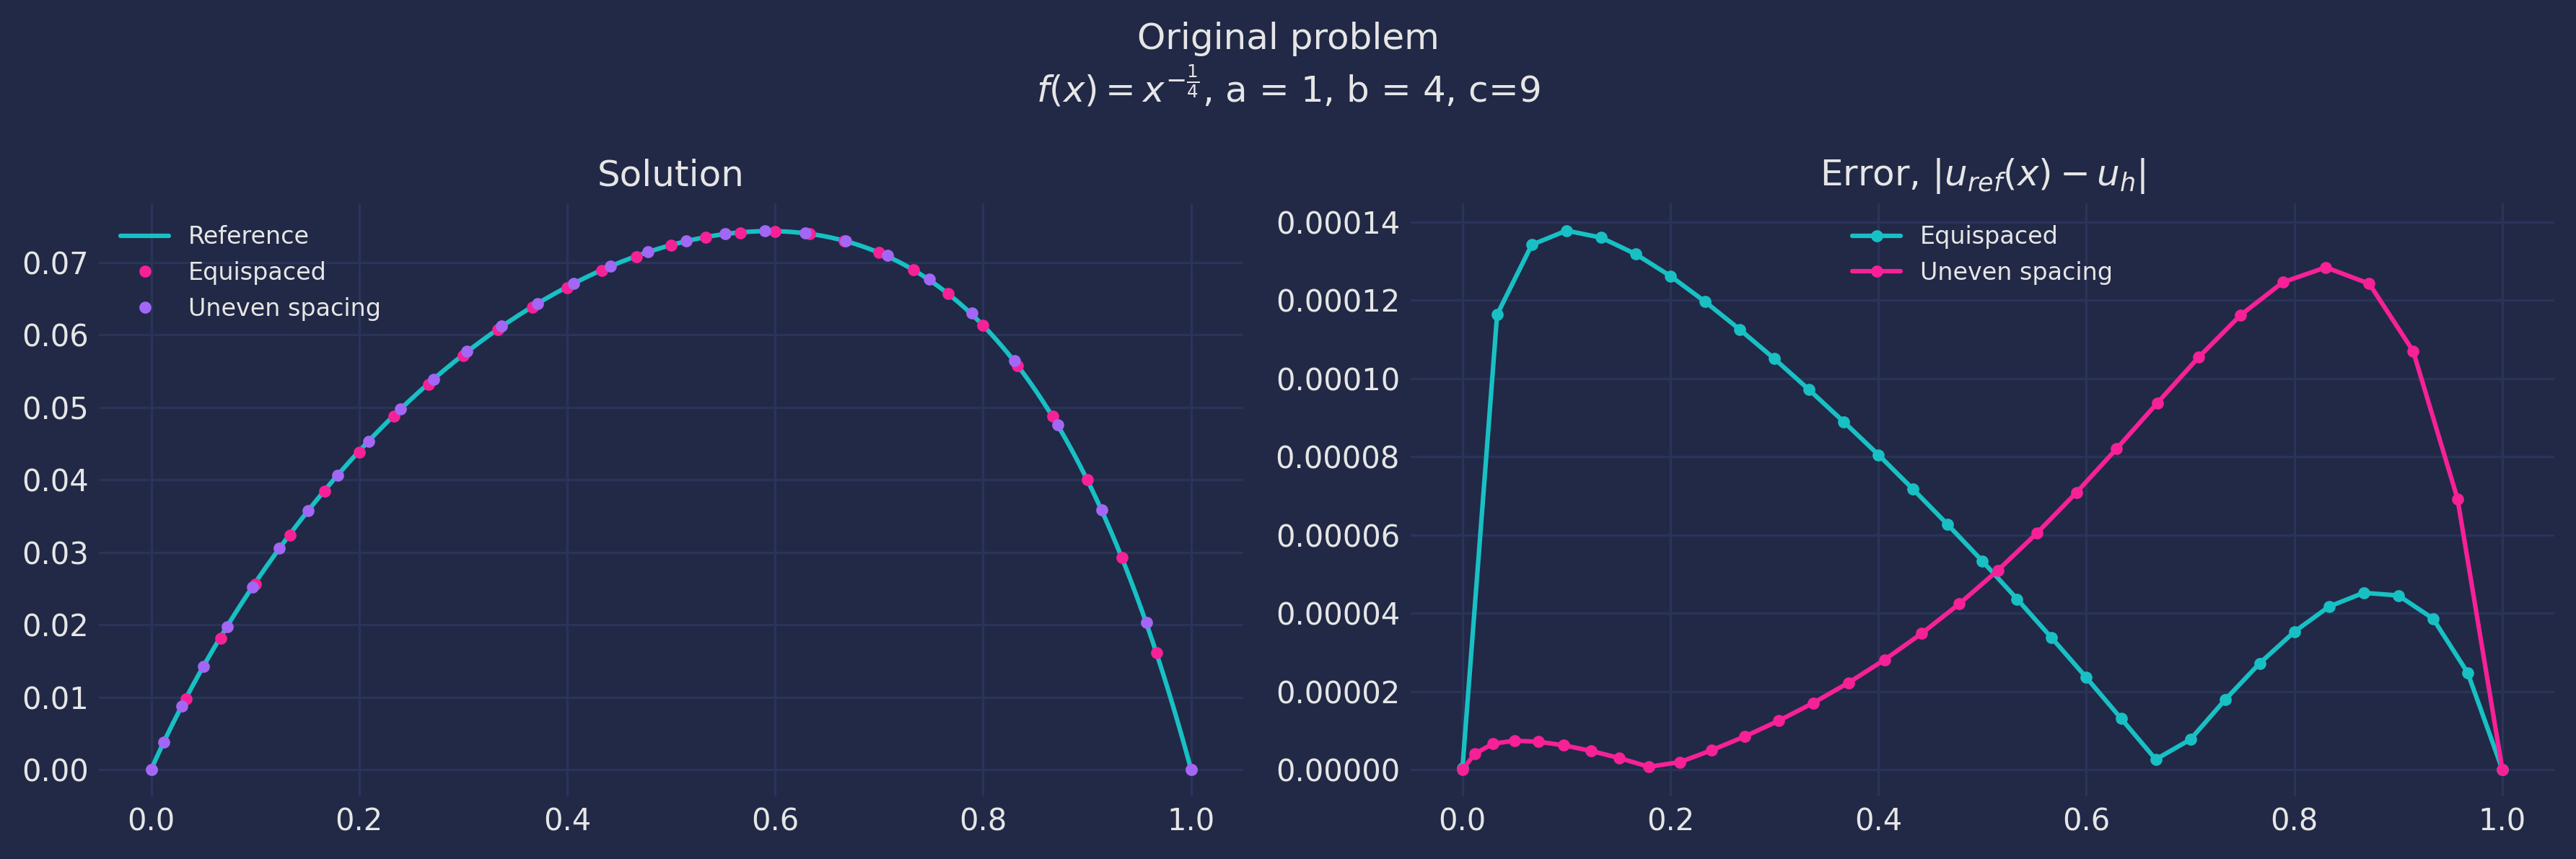

In [27]:
#Original problem
np.random.seed(0) #set seed¨
a, b, c = 1, 4, 9

def f(x, a, b, c):
    return x**(-1/4)

N_ref = 1000 #fixed number of subintervals for the reference solution
N = 30

x_equi = np.linspace(1e-6, 1, N + 1) #equispaced
x_uneven = x_equi**1.3

x_ref = np.linspace(1e-6, 1, N_ref+1) #equispaced, ref sol.
x_ref = np.union1d(x_uneven, x_ref)

U_equi = FEM(x_equi,f,a,b,c)
U_uneven = FEM(x_uneven,f,a,b,c)

U_ref = FEM(x_ref,f,a,b,c)
u_ref = interpolate.interp1d(x_ref, U_ref)

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Original problem\n" + r"$f(x) = x^{-\frac{1}{4}}$"+f", a = {a}, b = {b}, c={c}")
axs[0].set_title("Solution")
axs[0].plot(x_ref, U_ref, label = "Reference")
axs[0].plot(x_equi, U_equi, '.',label = "Equispaced")
axs[0].plot(x_uneven, U_uneven, '.',label = "Uneven spacing")
axs[0].legend()

axs[1].set_title(r"Error, $|u_{ref}(x)-u_h|$")
axs[1].plot(x_equi, abs(u_ref(x_equi)-U_equi),'.-' ,label = "Equispaced")
axs[1].plot(x_uneven, abs(u_ref(x_uneven)-U_uneven),'.-' ,label = "Uneven spacing")
axs[1].legend()
plt.tight_layout()
plt.savefig("OriginalProblem.png")
plt.show()